In [2]:
import aotools
import numpy as np
import matplotlib.pyplot as plt


In [3]:
N = 2**10
obscuration = 0.3
r0 = 0.3
L0,l0 = 10,0.00001
D = 0.7
f = 8.41
wvl = 1550e-9
width = 64

In [4]:
import multiprocessing
N_CPU = multiprocessing.cpu_count()
from threading import Thread

# python3 has queue, python2 has Queue
try:
    import queue
except ImportError:
    import Queue as queue

import numpy
import numba
import numpy as np
from scipy.interpolate import RegularGridInterpolator





def bilinear_interp(data, xCoords, yCoords, interpArray, bounds_check=True):
    """
    A function which deals with numba interpolation.

    Parameters:
        array (ndarray): The 2-D array to interpolate
        xCoords (ndarray): A 1-D array of x-coordinates
        yCoords (ndarray): A 2-D array of y-coordinates
        interpArray (ndarray): The array to place the calculation
        bounds_check (bool, optional): Do bounds checkign in algorithm? Faster if False, but dangerous! Default is True
    Returns:
        interpArray (ndarray): A pointer to the calculated ``interpArray''
    """
    if bounds_check:
        bilinear_interp_numba(data, xCoords, yCoords, interpArray)
    else:
        bilinear_interp_numba_inbounds(data, xCoords, yCoords, interpArray)

    return interpArray

@numba.jit(nopython=True, parallel=True)
def bilinear_interp_numba(data, xCoords, yCoords, interpArray):
    """
    2-D interpolation using purely python - fast if compiled with numba
    This version also accepts a parameter specifying how much of the array
    to operate on. This is useful for multi-threading applications.

    Bounds are checks to ensure no out of bounds access is attempted to avoid
    mysterious seg-faults

    Parameters:
        array (ndarray): The 2-D array to interpolate
        xCoords (ndarray): A 1-D array of x-coordinates
        yCoords (ndarray): A 2-D array of y-coordinates
        interpArray (ndarray): The array to place the calculation

    Returns:
        interpArray (ndarray): A pointer to the calculated ``interpArray''
    """
    jRange = range(yCoords.shape[0])
    for i in numba.prange(xCoords.shape[0]):
        x = xCoords[i]
        if x >= data.shape[0] - 1:
            x = data.shape[0] - 1 - 1e-9
        x1 = numba.int32(x)
        for j in jRange:
            y = yCoords[j]
            if y >= data.shape[1] - 1:
                y = data.shape[1] - 1 - 1e-9
            y1 = numba.int32(y)

            xGrad1 = data[x1 + 1, y1] - data[x1, y1]
            a1 = data[x1, y1] + xGrad1 * (x - x1)

            xGrad2 = data[x1 + 1, y1 + 1] - data[x1, y1 + 1]
            a2 = data[x1, y1 + 1] + xGrad2 * (x - x1)

            yGrad = a2 - a1
            interpArray[i, j] = a1 + yGrad * (y - y1)
    return interpArray



In [5]:

class phaseScreen(object):
    # Using Stategy Pattern to generate the phase screens using and 
    # arbitrary generator function. E.g. Zernike, KL, Kolmogorov, etc.
    def __init__(self, N, strategy, generatorParameters):
        self.N = N
        self.generator = strategy
        self.generatorParameters = generatorParameters
        # Placeholder Attributes
        self.scrn = np.zeros((N,N))
    def setParams(self, **kwargs):
        self.generatorParameters = kwargs
    def generate(self, **kwargs):
        self.scrn = self.generator.generate(self.N, **self.generatorParameters)
        return self.scrn
    def decompose(self, type="zernike",nModes=50):
        if type == "zernike":
            mask = aotools.circle(self.N//2,self.N)
            A = mask*self.scrn
            Z = aotools.zernikeArray(nModes, self.N)
            z = np.array([np.trace(Zj.conj().T @ A ) for Zj in Z]) /self.N**2
            return z
        else:
            # Generate Error
            raise ValueError("Decomposition type not recognised")

# Generator Interface
class generatorStrategy(object):
    def generate(self, N, **kwargs):
        pass

class finitePhaseScreen(generatorStrategy):
    def generate(self, N, **kwargs):
        # unpack the parameters
        r0 = kwargs['r0']
        delta = kwargs['delta']
        L0,l0 = kwargs['L0'], kwargs['l0']
        subHarmonics = kwargs['subHarmonics']
        if subHarmonics == True:
            screen = aotools.turbulence.phasescreen.ft_sh_phase_screen(r0, N, delta, L0, l0)
        else:
            screen = aotools.turbulence.phasescreen.ft_phase_screen(r0, N, delta, L0, l0)
        return screen

finitePhaseScreenParms = {'r0': r0, 'delta': D/N, 'L0': L0, 'l0': l0, 'subHarmonics': False}
phaseScreenGenerator = phaseScreen(N, finitePhaseScreen(), finitePhaseScreenParms)
    



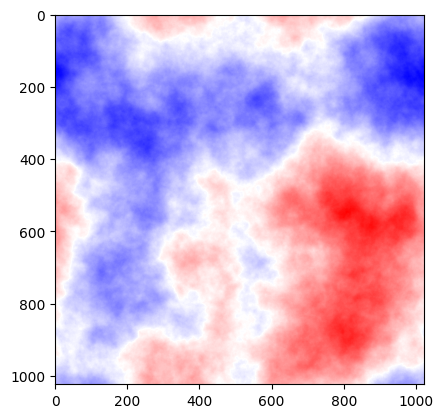

In [6]:
P = phaseScreenGenerator.generate()
plt.imshow(P,cmap='bwr')

In [7]:

pupil_size = 256

fov = 2*np.arctan(D/(2*f))

FoVPxNo = int(D*fov / wvl)
print(FoVPxNo)
sim_pad = 2

37567


In [8]:
interp_coords = np.linspace(-sim_pad, sim_pad+pupil_size,FoVPxNo)
interpArray = np.zeros((FoVPxNo,FoVPxNo))

bilinear_interp_numba(P, interp_coords, interp_coords, interpArray)

array([[-0.49486634, -0.47155336, -0.47162948, ...,  0.92523464,
         0.9252504 ,  0.92526617],
       [-0.49313605, -0.47015345, -0.47017163, ...,  0.96005151,
         0.96021621,  0.96038091],
       [-0.49324051, -0.4702993 , -0.47031773, ...,  0.95971734,
         0.95988122,  0.96004509],
       ...,
       [-1.49531679, -1.50695754, -1.50698741, ..., -0.84782068,
        -0.84786372, -0.84790677],
       [-1.49519638, -1.5068712 , -1.50690165, ..., -0.84789268,
        -0.84793575, -0.84797882],
       [-1.49507598, -1.50678485, -1.50681589, ..., -0.84796469,
        -0.84800778, -0.84805088]])

In [10]:
print(f"interpArray Shape {interpArray.shape}")


interpArray Shape (37567, 37567)
